# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [ ]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *
from CubicGalileonEmu.mcmc import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt


if_train_all = False ## Re-train all the models. Time-consuming. 
if_mcmc_all = False  ## Full MCMC run. Time-consuming. 
if_savefig = False

### Loading files

In [ ]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

### A few plotting routines

#### Experimental design

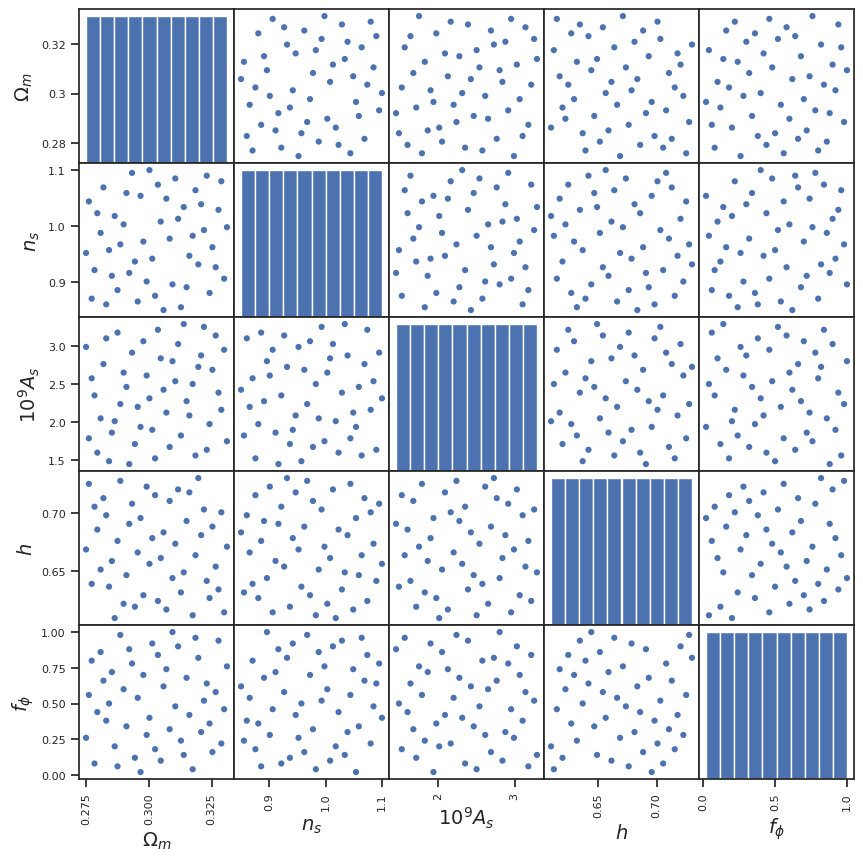

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);



#### Boost metrics colored by cosmology parameters

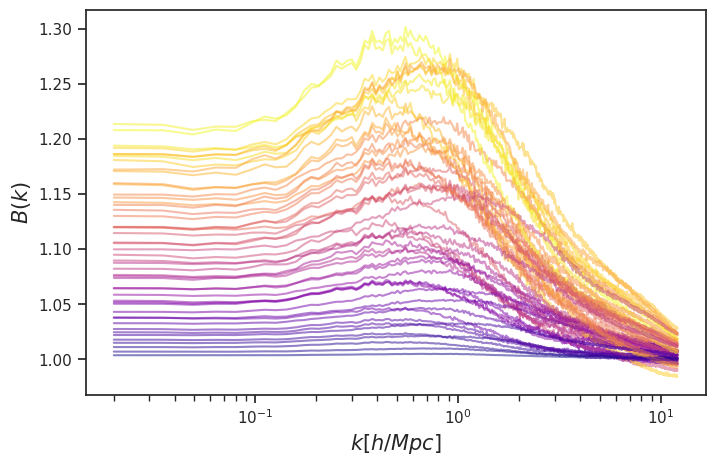

In [ ]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

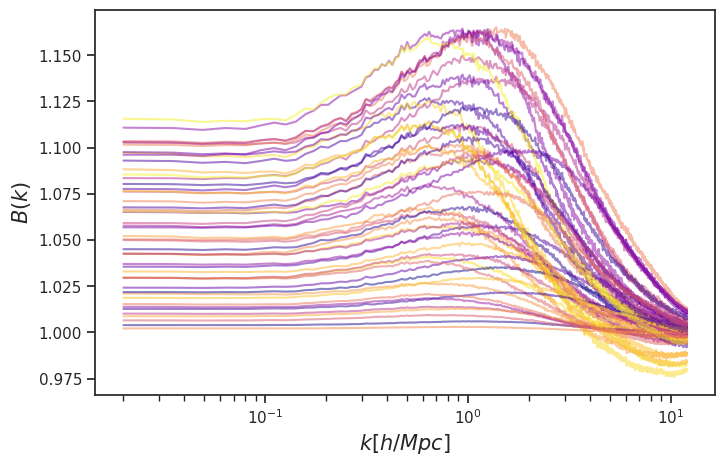

In [ ]:
#| hide 

color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

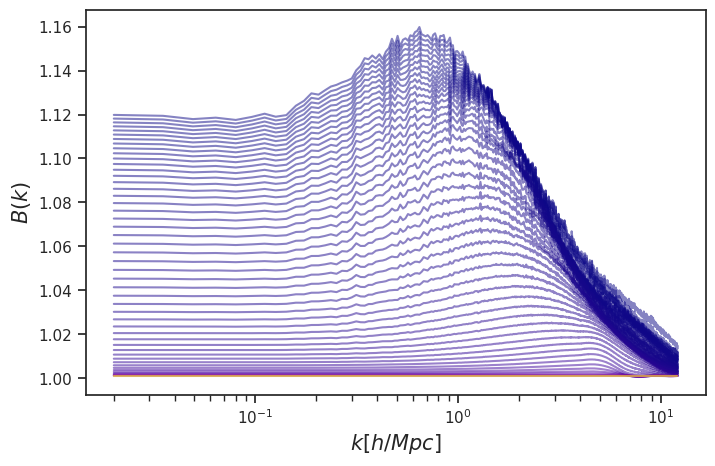

In [ ]:
#| hide 

z_index = 0

f = plot_lines_with_param_color(z_all, 
                            k_all, 
                            Bk_all[16, :, :], 
                            'Training data', 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            'redshift');

### Training involves: PCA, GP fitting.  

In [ ]:
## Data prep
z_index = 1
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all

# Train-test split
test_indices = [0, 14, 35]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(49) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = Bk_all[:, z_index, :][train_indices]
print('Redshift: ' + str(z_all[z_index]))

Redshift: 0.02


This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    46 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.44it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.5350586  0.45501813]
 [0.05788595 0.17961107]
 [0.14737768 0.70942058]
 [0.06837059 0.75057917]
 [0.12958195 0.62492375]
 [1.01379423 0.68263656]]
lamUz
[[1.2487563  1.17390664]]
lamWs
[[ 531.57792573 3215.53679708]]
lamWOs
[[13.22296244]]


MCMC sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.03it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index1.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

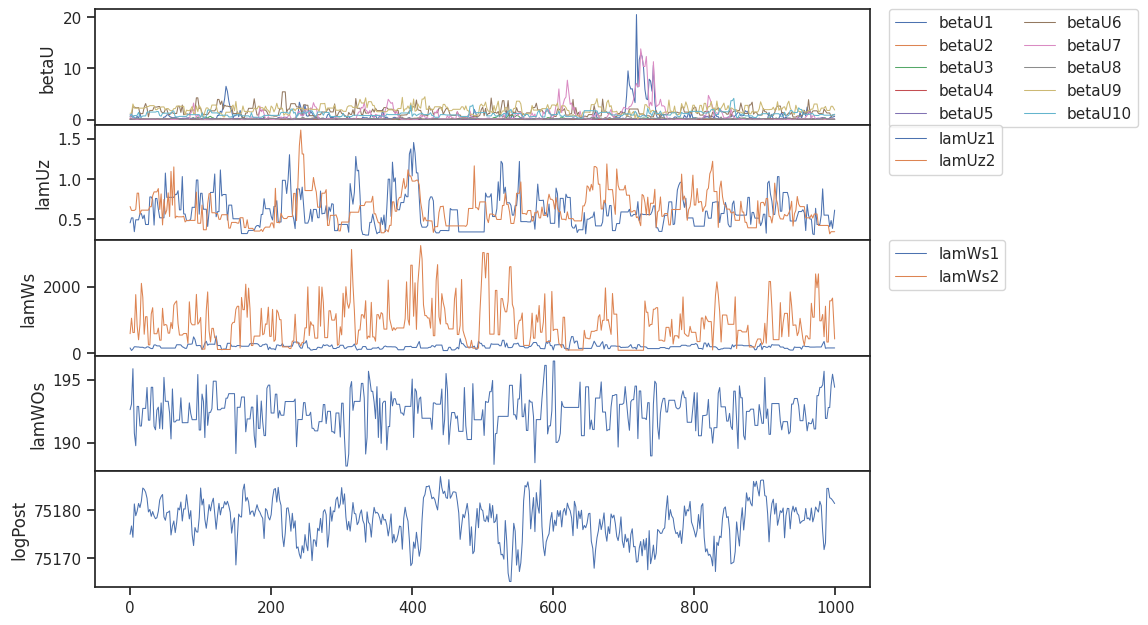

In [ ]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

### Single-redshift emulation for new cosmological parameters

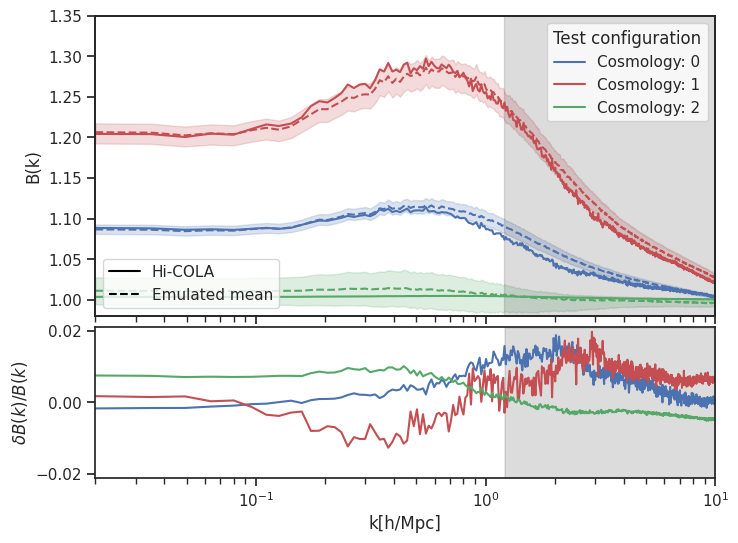

In [ ]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
# pred_quant == Emulated (0.05, 0.95) quantile
validation_plot(k_all, target_vals, pred_mean, pred_quant, xy_lims=[2e-2, 1e1, 0.98, 1.35]);

### Sensitivity analysis from the emulator 

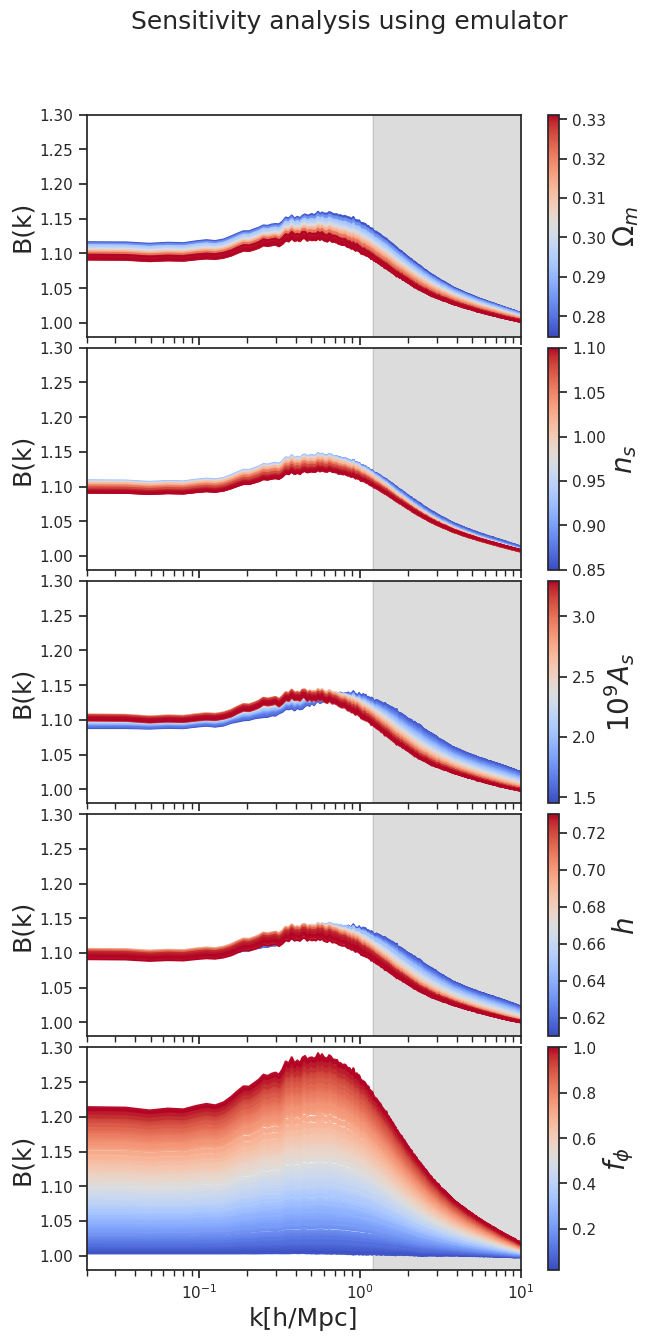

In [ ]:
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME)

### Multi-redshift emulation

#### Train all the models

In [ ]:
if if_train_all:
    
    do_gp_train_multiple(model_dir='../CubicGalileonEmu/model/', 
                        p_train_all = p_all[train_indices],
                        y_vals_all = Bk_all[train_indices],
                        y_ind_all = k_all,
                        z_index_range=range(49))

#### Load all trained models 

In [ ]:
sepia_model_list = load_model_multiple(model_dir='../CubicGalileonEmu/model/', 
                                        p_train_all=p_all[train_indices],
                                        y_vals_all=Bk_all[train_indices],
                                        y_ind_all=k_all,
                                        z_index_range=range(49), 
                                        sepia_model_i=sepia_model)

Number of models loaded: 49
[[0.31051392 1.085      2.541      0.67373333 0.480012   0.05      ]]
redshift:  0.085
Burn-in phase
time (minutes): 1.704698419570923
Sampling phase
time (minutes): 5.425558777650197
mcmc results: 0.3073272405704777 1.0809741076474884 2.5457969494010455 0.6769692408492755 0.4747639613703526
[78.19332951 93.50972874 95.31001324 92.15885737 84.96417667]


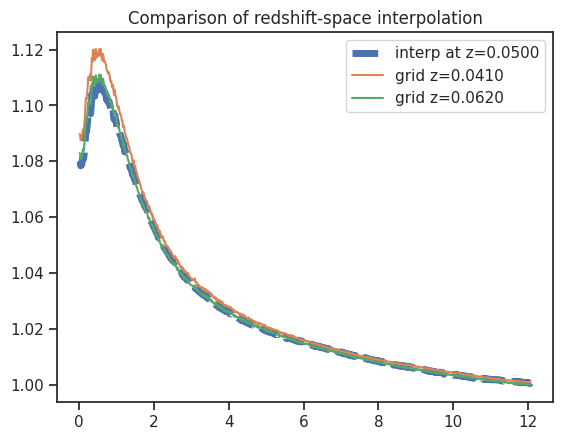

In [ ]:
#| hide

#### Emulator uncertainty across parameter range


input_params0 = input_params[0]
z_inputs = 0.05
input_params_and_redshift = np.append(input_params0, z_inputs)
print(input_params_and_redshift[np.newaxis, :])


emulated_with_redshift, emulated_with_redshift_err = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
## There is an unknown issue with z_index=5 model, (sepia_model_list[6])
emulate(sepia_model_list[6], input_params_and_redshift[:-1])[0]


plt.figure(433)
plt.plot(k_all, emulated_with_redshift[:, 0], label='interp at z=%.4f'%input_params_and_redshift[-1], lw=5, ls='--')
plt.plot(k_all, emulate(sepia_model_list[0], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[2])
plt.plot(k_all, emulate(sepia_model_list[1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[3])
plt.legend()
plt.title('Comparison of redshift-space interpolation')
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))

plt.show()

#### Emulator confidence across parameter range

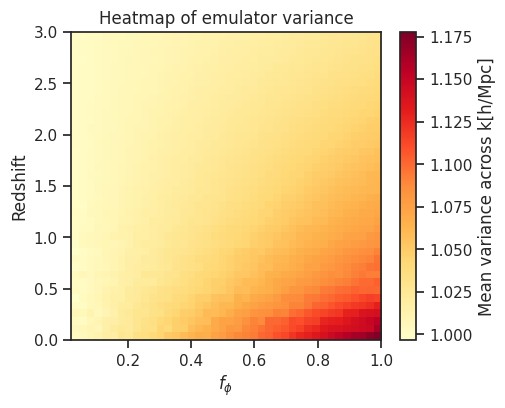

In [ ]:
# Parameter settings
steps = 40  # Number of steps in the grid for each parameter
param_name_extended = np.append(PARAM_NAME, 'Redshift')

param_min = np.append(p_all.min(axis=0), 0)
param_max = np.append(p_all.max(axis=0), 3)
param_mean = np.append(p_all.mean(axis=0), 1.0)

# Compute outputs and errors for a range of parameter values
def compute_errors(param_grid):
    errors = np.array([np.mean(emu_redshift(params[np.newaxis, :], sepia_model_list, z_all)[1][:, 0, :]**2)
                       for params in param_grid])
    return errors.reshape(steps, steps)

# Example usage:
param_indices = [4, 5]  # Indices of parameters to vary
fixed_indices = [i for i in range(len(param_name_extended)) if i not in param_indices]
fixed_params = {param_name_extended[i]: param_mean[i] for i in fixed_indices}

param_grid = generate_param_grid_with_fixed(param_name_extended, param_indices, fixed_params, param_min, param_max, steps)
errors = compute_errors(param_grid)
f = plot_error_heatmap(errors, [param_name_extended[i] for i in param_indices], [(param_min[param_indices[0]], param_max[param_indices[0]]), (param_min[param_indices[1]], param_max[param_indices[1]])])

if if_savefig: 
    f.savefig('../../../Plots/heatmap_params_4_5.png', bbox_inches='tight')

### Parameter inference via MCMC using the emulator

In [ ]:
#| hide 

ndim = 5
nwalkers = 50  # 500
nrun_burn = 100  # 300
nrun = 400  # 700

#### Creating mock observational data

In [ ]:

target_indx = 0 #0 ,14, 35
z_index = 4
L = 32
fake_obs_data_index_every = 2

redshift = z_all[z_index]
x = k_all[::fake_obs_data_index_every]
y = Bk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]
y = y + 1e-3*np.random.normal(0.0, 1.0, size=y.shape)
yerr = np.sqrt( Bk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]*(L**3))/(L**3)

x_grid = k_all
params_calib = p_all[target_indx][:, np.newaxis].T
print('redshift: ', redshift)

<matplotlib.legend.Legend>

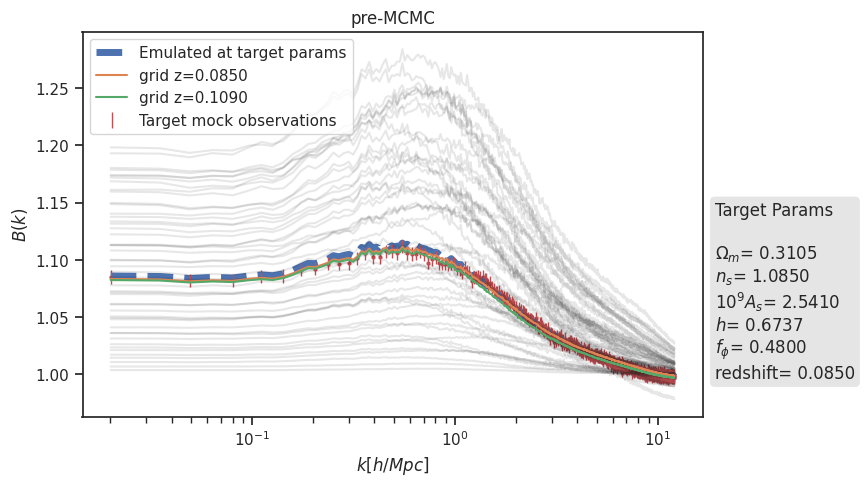

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(params_calib, redshift)
bk_target, err_target = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_target[:, 0], label='Emulated at target params', lw=5, ls='--')
a.errorbar(x, y, yerr, label='Target mock observations', ls='none', lw=1, color = "r")
a.scatter(x, y, s = 5, marker = "h", color = "r")


a.plot(k_all, Bk_all[:, z_index, :].T, 'k', alpha=0.1)


plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index])
plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index + 1])

string_print0 = 'Target Params \n\n' 
string_print1 = PARAM_NAME[0] + '= %.4f'%input_params_and_redshift[0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.4f'%input_params_and_redshift[1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.4f'%input_params_and_redshift[2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.4f'%input_params_and_redshift[3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.4f'%input_params_and_redshift[4] + '\n'
string_print6 = 'redshift' + '= %.4f'%input_params_and_redshift[5] 


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.1, string_print, transform=a.transAxes, fontsize=12, bbox=props)


a.set_xscale('log')
plt.title('pre-MCMC')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$B(k)$')
plt.legend()

In [ ]:
#| hide 

allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)

param1 = [PARAM_NAME[0], params_calib[0][0], allMin[0], allMax[0]] 
param2 = [PARAM_NAME[1], params_calib[0][1], allMin[1], allMax[1]]
param3 = [PARAM_NAME[2], params_calib[0][2], allMin[2], allMax[2]]
param4 = [PARAM_NAME[3], params_calib[0][3], allMin[3], allMax[2]]
param5 = [PARAM_NAME[4], params_calib[0][4], allMin[4], allMax[4]]

params_list = [param1, param2, param3, param4, param5]

In [ ]:
pos0 = chain_init(params_list, ndim, nwalkers)
sampler = define_sampler(redshift, ndim, nwalkers, params_list, x_grid, sepia_model_list, z_all, x, y, yerr)

##### MCMC run - first burn, then full. 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [05:30<00:00,  1.21it/s]


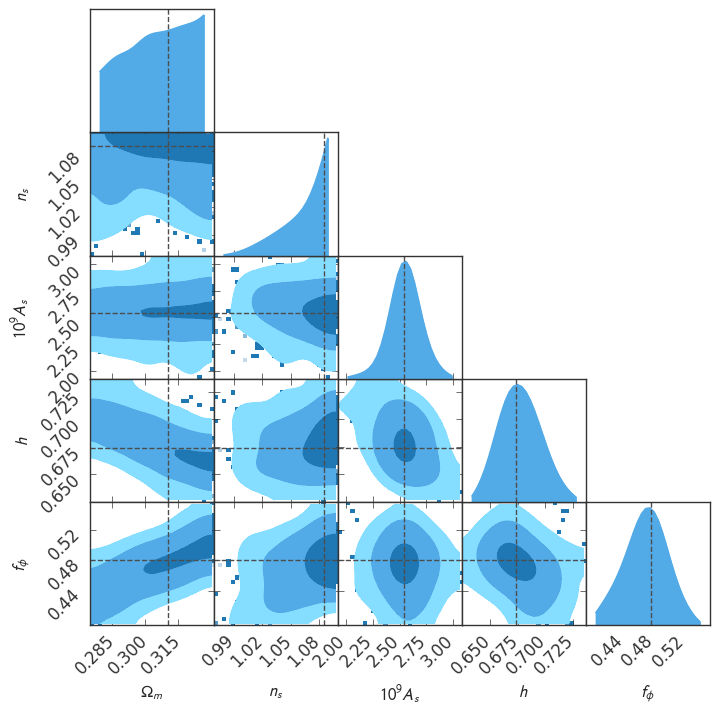

In [ ]:

pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos0, nrun_burn, ndim, if_burn=True)

if if_mcmc_all: # Full MCMC-run, will be slow
    pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos, nrun, ndim, if_burn=False)

p_mcmc = mcmc_results(samples)

fig = plot_mcmc(samples, params_list, if_truth_know=True)
if if_savefig: 
    plt.savefig('../../../Plots/mcmc_plot.png', bbox_inches='tight')

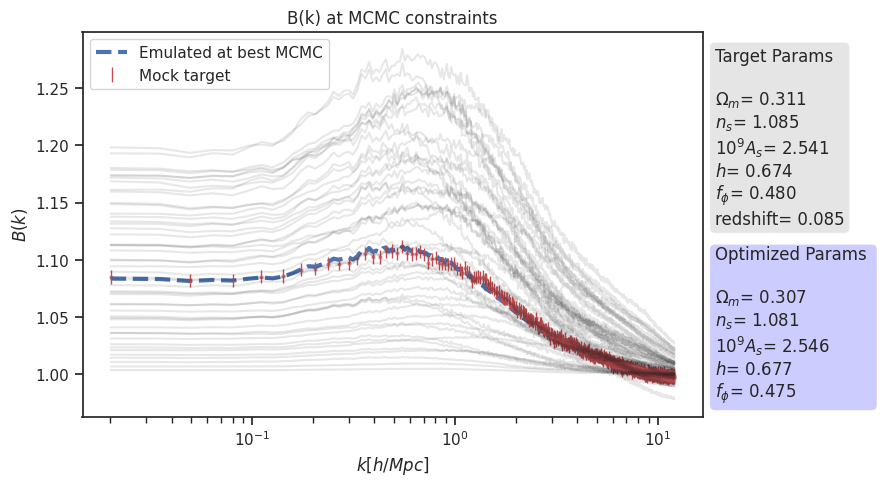

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(p_mcmc, redshift)
bk_mcmc, err_mcmc = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_mcmc[:, 0], label='Emulated at best MCMC', lw=3, ls='--')
a.errorbar(x, y, yerr, label='Mock target', ls='none', lw=1, color = "r")
a.scatter(x, y, s = 5, marker = "h", color = "r", alpha=0.5)

a.plot(k_all, Bk_all[:, z_index, :].T, 'k', alpha=0.1)


# plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='Z1')
# plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='Z2')

string_print0 = 'Target Params \n\n' 
string_print1 = PARAM_NAME[0] + '= %.3f'%params_calib[0][0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.3f'%params_calib[0][1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.3f'%params_calib[0][2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.3f'%params_calib[0][3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.3f'%params_calib[0][4] + '\n'
string_print6 = 'redshift' + '= %.3f'%redshift


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.5, string_print, transform=a.transAxes, fontsize=12, bbox=props)

string_print0_mcmc = 'Optimized Params \n\n' 
string_print1_mcmc = PARAM_NAME[0] + '= %.3f'%p_mcmc[0] + '\n'
string_print2_mcmc = PARAM_NAME[1] + '= %.3f'%p_mcmc[1] + '\n'
string_print3_mcmc = PARAM_NAME[2] + '= %.3f'%p_mcmc[2] + '\n'
string_print4_mcmc = PARAM_NAME[3] + '= %.3f'%p_mcmc[3] + '\n'
string_print5_mcmc = PARAM_NAME[4] + '= %.3f'%p_mcmc[4] 

string_print_mcmc = string_print0_mcmc + string_print1_mcmc + string_print2_mcmc + string_print3_mcmc + string_print4_mcmc + string_print5_mcmc

props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
plt.text(1.02, 0.05, string_print_mcmc, transform=a.transAxes, fontsize=12, bbox=props)



a.set_xscale('log')
plt.title('B(k) at MCMC constraints')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$B(k)$')
plt.legend()

if if_savefig: 
    plt.savefig('../../../Plots/mcmc_results_Bk.png', bbox_inches='tight')


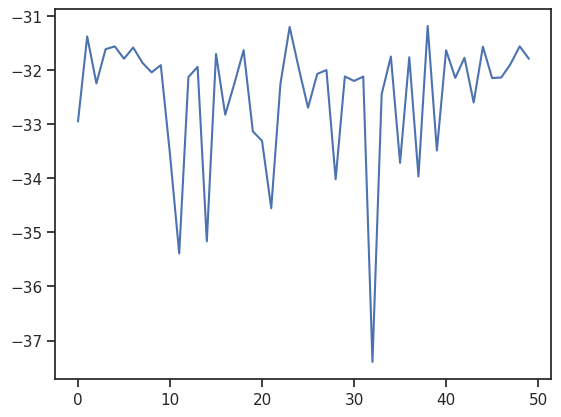

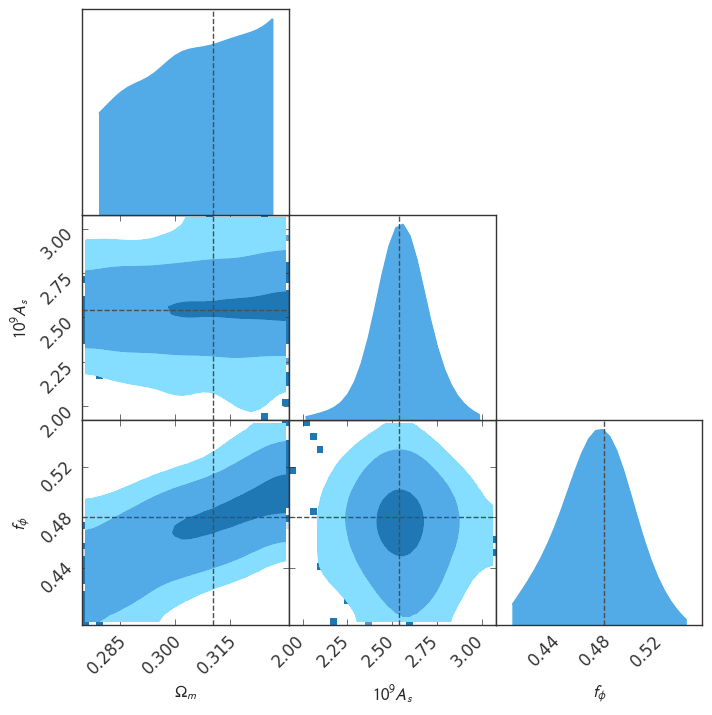

In [ ]:
#| hide


if if_mcmc_all:
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)

    plt.figure(43)
    plt.plot(prob)
    if if_savefig: 
        plt.savefig('../../../Plots/prob_plot.png', bbox_inches='tight')

    selected_indices_for_plot = [0, 2, 4]
    fig = plot_mcmc(samples[:, selected_indices_for_plot], [params_list[i] for i in selected_indices_for_plot], if_truth_know=True)

    if if_savefig: 
        plt.savefig('../../../Plots/mcmc_plot_reduced_params.png', bbox_inches='tight')

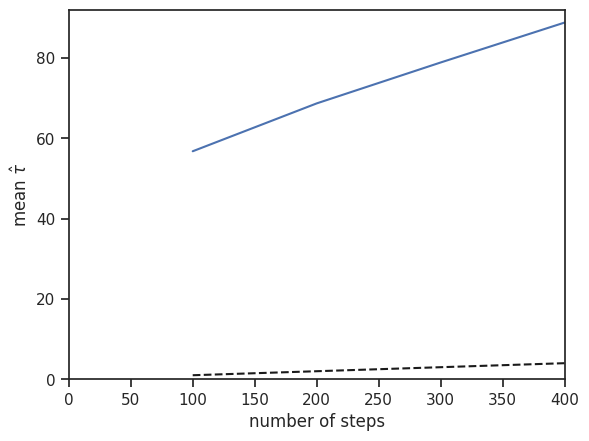

In [ ]:
#| hide

if if_mcmc_all:

    n = 100 * np.arange(1, index + 1)
    y = autocorr[:index]
    plt.plot(n, n / 100.0, "--k")
    plt.plot(n, y)
    plt.xlim(0, n.max())
    plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
    plt.xlabel("number of steps")
    plt.ylabel(r"mean $\hat{\tau}$");
    plt.show()

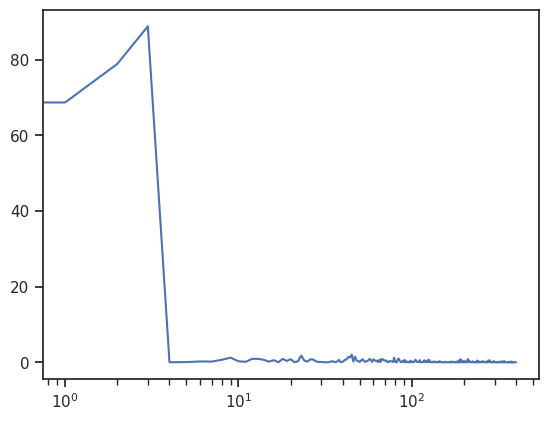

In [ ]:
#| hide

if if_mcmc_all:
    plt.plot(autocorr)
    plt.xscale('log')
    # plt.yscale('log')